# Business Understanding

## Overview 
The dataset we chose contains car evaluation data derived from a hierarchical decision model developed initially for a demonstration of a decision making model and can be found at [[1]](#footnote1). The authors The dataset contains 6 attributes related to either price or technical characteristics. The 7th attribute represents the estimated class of the car and is based on all other attributes. The dataset consists of 1728 entries and is stripped of structural attributes, which means all attributes are directly related to the estimated car class attribute. There are also three intermediate attributes – PRICE, TECH and COMFORT – which are related to the 6 main attributes. 
## Use case
Choosing a vehicle to purchase can be a tedious process that involves hours of research, with studies showing American drivers spend an average of around 15 hours between realizing the need for a new car and making the purchase [[2]](#footnote2). 60% of this time is usually spent in online research of specifications and availability. Generally, although the most important attribute of a car is its ability to transport, the final decision is very often based on an amalgam of its price, safety and capacity. The main purpose for the collection of the dataset we chose was to “actively support the decision maker in the knowledge acquisition and evaluation stages of the decision making process” [[3]](#footnote3). 
## Prediction task
The dataset uses a simple hierarchical model to classify cars in one of 4 categories: Unacceptable (unacc), Acceptable (acc), Good (good), Very Good (vgood). The criteria tree is displayed below. The goal of our prediction task is to correctly identify the class associated with the car based on the 6 attributes that are used in the evaluation model, without specifying the model structure itself. 


<img src='tree.png' label="Criteria tree"/ height=500 width=500>
This could be useful in many different scenarios, such as helping manufacturers determine whether or not a new car would be well accepted by the market. Even after years of research and development, some car manufacturers suffer big financial losses due to lack of proper competitor analysis in the market and target audience expectations [[4]](#footnote4). Thus, for our evaluation criteria on this dataset, we aim to maximize the number of correctly predicted car classes in the range unacceptable and very good, as described above. The higher the percentage, the more reliable and valuable our algorithm will be to said manufacturers upon releasing a new vehicle to the market. 

As a benchmark to compare our algorithm against, we consider how accurate car manufacturers are now about predicting how successful their newest model will be. Since the actual predictions a car company has for their models is not public information, we use a proxy to approximate the prediction accuracy: the percentage of cars on the market that are acceptable, good, or very good. We assume that the goal of a car company is to produce a car that is not unacceptable. Thus, the percentage of cars on the market that are unacceptable is similar to the prediction error that car manufacturers exhibit. In our data set, 70% of the cars are unacceptable. Thus, we estimate for the purposes of this exercise that car manufacturers have a 30% accuracy rate in predicting the acceptability of cars.


The simplicity of the hierarchical decision model used in the training set could be a limitation to this performance and reliability, as we are only basing our results on the 6 attributes that are provided. A further drawback is the fact that all attributes are nominally assigned, which would fail to account for small differences of attribute values near the hard cutoff limits. 

 

### References
&nbsp;<a name="footnote1">1</a>: https://archive.ics.uci.edu/ml/datasets/Car+Evaluation <br>
&nbsp;<a name="footnote2">2</a>: https://www.elephant.com/blog/car-insurance/new-study-details-how-long-it-takes-before-car-shoppers-buy <br>
&nbsp;<a name="footnote3">3</a>: http://kt.ijs.si/MarkoBohanec/pub/Avignon88.pdf <br>
&nbsp;<a name="footnote4">4</a>: https://www.popularmechanics.com/cars/g1766/10-cars-that-deserved-to-fail/?slide=3 <br>



# Data Preparation

In [1]:
#Imports
#import s # Business Understandingcipy
import scipy
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from scipy.special import expit
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv('car.data')
buying_maint_map = {'vhigh':3,'high':2,'med':1,'low':0}
df['buy_price'] = df['buy_price'].map(buying_maint_map).astype(np.int)
df['maint_price'] = df['maint_price'].map(buying_maint_map).astype(np.int)
doors_map = {'2':0,'3':1,'4':2,'5more':3}
df['doors'] = df['doors'].map(doors_map).astype(np.int)
persons_map = {'2':0,'3':1,'4':2,'more':3}
df['persons'] = df['persons'].map(persons_map).astype(np.int)
trunk_map = {'small':0,'med':1,'big':2}
df['trunk_size'] = df['trunk_size'].map(trunk_map).astype(np.int)
safety_map = {'low':0,'med':1,'high':2}
df['safety'] = df['safety'].map(safety_map).astype(np.int)
class_map = {'unacc':0,'acc':1,'good':2,'vgood':3}
df['class'] = df['class'].map(class_map).astype(np.int)


feature_cols = ['buy_price','maint_price','doors','persons','trunk_size','safety']
class_cols = ['class']

unacc_percent = len(df[df['class']==0])/len(df['class'])
print('Percent of cars that are unacceptable:',unacc_percent)

#Make X a 2D numpy array
X = df[feature_cols].as_matrix()
#Make y a 1D numpy array
y = (df[class_cols]==0).astype(np.int).values.ravel()
y_not_binary = (df[class_cols]).astype(np.int).values.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y_not_binary, test_size=0.2, shuffle=True)


Percent of cars that are unacceptable: 0.7002314814814815


The only data processing/preparation we do is to convert the text categories such as 'vhigh', 'small', 'unacc', etc. into integer values. Since these classes are ordered, we use integers instead of one-hot encoding.

# 80/20 Split

Splitting 80/20 is problematic in these cases: first, if there are not enough data; second, if the data have time dependence; third, if the split that was chosen randomly happens to show performance that is better or worse than the actual performance of the model. None of the three cases apply to our data. The first case, that there are not enough data, does not apply. Our data has 1,728 instances, which means that 346 instances are used in the test set. With 346 instances, lucky guesses have little effect; each instance represents less than 1 percent of the total result. The second case, that the data have time dependence, also does not apply. Time dependence exists in venues like finance, where stock price is a function of time. In our data set, new car models are not time dependent on old car models; it is not as if the number of doors that car models have increases over time. The third case, that the randomized 80/20 split happens to be a lucky one, is solved by running multiple randomizations. We run multiple randomizations to see how the model performs when trained and tested on different data to avoid the influence of one lucky guess.

An 80/20 split is also problematic when either the training or test set are used to optimize hyperparameters. The grid search that we will perform on the test set is data snooping because we are not pulling information form the relationship between the data but between our models and that specific dataset. To get around this we could break our set into train-test-validate sets. This would help ameliorate this issue. 


Nonetheless, Although it is not perfect an 80/20 split is sufficient for our specific purpose with this dataset. We want to analyze the differences between optimization methods so even though we are data snooping this does not greatly effect the relationships between optimization methods and regularizations. Splitting the dataset into a test set and a training set allows us to see how our models perform relatively to each other and that is the main goal of this excercise.



# Logistic Regression Modeling

## Binary Logistic Regression

In [2]:
#Taken from not# Business Understandingebook 6
class BinaryLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.001,l1_norm=0.5):
        self.eta = eta
        self.iters = iterations
        self.C = C
        if ((l1_norm > 1 or l1_norm < 0) and l1_norm != -1):
            raise ValueError("L1 Norm must be between 0 and 1 or -1")
        self.l1_norm = l1_norm
        # internally we will store the weights as self.w_ to keep with sklearn conventions
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # vectorized gradient calculation with regularization using L2 Norm
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        if (self.l1_norm == -1):
            return gradient
        return self._regularize(gradient)
    
    def _regularize(self,gradient):
        #Implementation for Elastic Net regularization 
        sub_1 = np.copy(gradient[1:])
        sub_2 = np.copy(gradient[1:])
        
        #Calculate L1 Norm 
        mask = np.logical_and(sub_1 >= (-self.C/2),sub_1 <= (self.C/2))
        sub_1[mask] = 0
        sub_1[sub_1 < (-self.C/2)] += (self.C / 2)
        sub_1[sub_1 > (self.C/2)] -= (self.C / 2)
        
        
        #Calculate L2 Norm
        sub_2 += -2 * self.w_[1:] * self.C
        
        #Combine the regularizations to make an elastic net.
        gradient[1:] = self.l1_norm * sub_1 + (1-self.l1_norm) * sub_2
        return gradient
        
    
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 

https://www.coursera.org/learn/ml-regression/lecture/SeZsT/coordinate-descent-for-lasso-normalized-features
Coursera link used to help derive the formula for L1 regularization.

### Stochastic Regression

In [3]:
%%time 
class StochasticLogisticRegression(BinaryLogisticRegression):
    # stochastic gradient calculation 
    def _get_gradient(self,X,y):
        idx = int(np.random.rand()*len(y)) # grab random instance
        ydiff = y[idx]-self.predict_proba(X[idx],add_bias=False) # get y difference (now scalar)
        gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        if (self.l1_norm == -1):
            return gradient
        return self._regularize(gradient)
    
    
slr = StochasticLogisticRegression(0.1,1000, C=0.001,l1_norm=1) # take a lot more steps!!

slr.fit(X,y)

yhat = slr.predict(X)
print(slr)
print('Accuracy of: ',accuracy_score(y,yhat))

Binary Logistic Regression Object with coefficients:
[[ 3.48013789]
 [ 1.11845977]
 [ 0.99242303]
 [-0.24405235]
 [-1.32642755]
 [-0.28168495]
 [-1.91197978]]
Accuracy of:  0.8732638888888888
Wall time: 41.6 ms


### Newton Regression

In [4]:
%%time
class NewtonLogisticRegression(BinaryLogisticRegression):
    def _hessian(self,X,y):
        g = self.predict_proba(X,add_bias=False).ravel()
        if (self.l1_norm == -1):
            return X.T @ np.diag(g*(1-g)) @ X - 2
        else:
            return X.T @ np.diag(g*(1-g)) @ X - 2 * (1-self.l1_norm) * self.C
    
    def fit(self,X,y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            inv_hessian = np.linalg.inv(self._hessian(Xb,y))
            self.w_ +=  inv_hessian@gradient*self.eta # multiply by learning rate 
            
nlr = NewtonLogisticRegression(0.1,10, C=0.001,l1_norm=0) # take a lot more steps!!
nlr.fit(X,y)

yhat = nlr.predict(X)
print(nlr)
print('Accuracy of: ',accuracy_score(y,yhat))

Binary Logistic Regression Object with coefficients:
[[ 1.37975242e-03]
 [ 1.93921083e-04]
 [ 1.72493226e-04]
 [-5.89276349e-05]
 [-3.67335919e-04]
 [-1.64726414e-04]
 [-6.00648741e-04]]
Accuracy of:  0.8923611111111112
Wall time: 167 ms


The above cells run the binary logistic regession object. They test the accuracy of the model in determining if a car is unacceptable or not. The accuracy for the Newton binary regression is 89%. It is worth noting that this accuracy is significantly better than the accuracy of the car industry at predicting if a car will be unacceptable. 70% of cars produced by the car industry are unacceptable; the industry can only predict if a car will be unacceptable 30% of the time. The Newton Logistic Regression predicts if a car will be unacceptable 89% of the time, a significant improvement.

## Multi Class Logistic Regression

In [5]:
class MultiClassLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.0001, optimize_func='steepest',l1_norm=0.5):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.classifiers_ = []
        self.optimize_func = optimize_func
        self.l1_norm = l1_norm
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = (y==yval).astype(np.int) # create a binary problem
            # train the binary classifier for this class
            if self.optimize_func == 'stochastic':
                hblr = StochasticLogisticRegression(self.eta,self.iters,self.C,l1_norm = self.l1_norm)
            elif self.optimize_func == 'steepest':
                hblr = BinaryLogisticRegression(self.eta,self.iters,self.C,l1_norm = self.l1_norm)
            elif self.optimize_func == 'newton':
                hblr = NewtonLogisticRegression(self.eta,self.iters,self.C,l1_norm = self.l1_norm)
            hblr.fit(X,y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(hblr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for hblr in self.classifiers_:
            probs.append(hblr.predict_proba(X).reshape((len(X),1))) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1) # take argmax along row
    



In [6]:
%%time
lr = MultiClassLogisticRegression(0.1,iterations=250,C=0.00001,optimize_func='steepest')
lr.fit(X,y_not_binary)
print(lr)

yhat = lr.predict(X)
print('Accuracy of: ',accuracy_score(y_not_binary,yhat))

MultiClass Logistic Regression Object with coefficients:
[[ 1.07241361  0.86258341  0.80408431  0.14023905 -0.82246482 -0.0731898
  -1.21356912]
 [-1.16057672 -0.36071249 -0.37714207 -0.18977163  0.4727244  -0.15508043
   0.64756361]
 [-0.52221446 -0.99670015 -0.99670015 -0.26945457  0.11810753 -0.27441964
   0.00443686]
 [-0.70688151 -1.02877499 -0.80201932 -0.2993838  -0.02292801 -0.02129836
   0.22804441]]
Accuracy of:  0.7644675925925926
Wall time: 169 ms


In [7]:
%%time
lr_st = MultiClassLogisticRegression(0.1,iterations=1000,C=0.00001,optimize_func='stochastic')
lr_st.fit(X,y_not_binary)
print(lr_st)

yhat_st = lr_st.predict(X)
print('Accuracy of: ',accuracy_score(y_not_binary,yhat_st))

MultiClass Logistic Regression Object with coefficients:
[[ 3.23573953  1.40490991  0.952468    0.09256354 -1.43673506 -0.26886826
  -2.45418166]
 [-3.34186005 -0.68334559 -0.37956769 -0.62416596  0.64320084 -0.14789376
   1.26025924]
 [-0.90929621 -1.71146451 -1.71864702 -0.25494204  0.5521885   0.15471586
   0.37207313]
 [-1.70696888 -1.44643865 -1.16166654 -0.45651797  0.19303195  0.07559244
   0.84638197]]
Accuracy of:  0.7563657407407407
Wall time: 168 ms


In [8]:
%%time
lr = MultiClassLogisticRegression(0.1,iterations=20,C=0.00001,optimize_func='stochastic',l1_norm=0.5)
lr.fit(X,y_not_binary)
print(lr)
print (lr.l1_norm)

yhat = lr.predict(X)
print('Accuracy of: ',accuracy_score(y_not_binary,yhat))

MultiClass Logistic Regression Object with coefficients:
[[ 0.13058711  0.39695863  0.26202726  0.40802888 -0.09848253 -0.14909984
  -0.35552601]
 [-0.32815671 -0.47204137 -0.36678705 -0.09012516 -0.23802162 -0.2050425
  -0.26206281]
 [-0.24776735 -0.53697941 -0.3222443  -0.4192404  -0.28946586 -0.2793639
  -0.19873499]
 [-0.22920402 -0.38079317 -0.32999084 -0.23510161 -0.26842772 -0.07276999
  -0.16790873]]
0.5
Accuracy of:  0.6984953703703703
Wall time: 7 ms


## Multi Class Logistic Regression Hyperparameter Optimization

In [9]:
%%time
import copy
#We tested C's above 1 and they all offer same results. 
c_list = [0.0001,0.001,0.01,0.1,1,10]#,0.0001,0.001,0.01,0.1,1,10]
optimization_list = ['newton','stochastic','steepest']
regularization_list = [1,0,.5,-1]
eta = 0.1

iterations = {
    'newton':3,
    'stochastic':1000,
    'steepest':1000
}
tests = {}
results = {}
weights = {}

tests = dict.fromkeys(regularization_list,dict.fromkeys(optimization_list,[]))
results = []#dict.fromkeys(regularization_list,dict.fromkeys(optimization_list,[]))
weights = []

print (results)

for regularization in regularization_list:
    for optimization in optimization_list:
        for c in c_list:
            test = None
            test = MultiClassLogisticRegression(eta,iterations=iterations[optimization],C=float(c),optimize_func=optimization,l1_norm=float(regularization))
            test.fit(X_train,y_train)
            yhat = test.predict(X_test)
            score = accuracy_score(y_test,yhat)
            print("Norm:",regularization,'| Method:',str(optimization),'| C:',str(c),'| Accuracy of: ',score)
            results.append(score)
            weights.append(test.w_)
            #print(test.w_)
        print()
    print()
    print()
            

[]
Norm: 1 | Method: newton | C: 0.0001 | Accuracy of:  0.7658959537572254
Norm: 1 | Method: newton | C: 0.001 | Accuracy of:  0.7658959537572254
Norm: 1 | Method: newton | C: 0.01 | Accuracy of:  0.7630057803468208
Norm: 1 | Method: newton | C: 0.1 | Accuracy of:  0.7485549132947977
Norm: 1 | Method: newton | C: 1 | Accuracy of:  0.4913294797687861
Norm: 1 | Method: newton | C: 10 | Accuracy of:  0.47109826589595377

Norm: 1 | Method: stochastic | C: 0.0001 | Accuracy of:  0.7572254335260116
Norm: 1 | Method: stochastic | C: 0.001 | Accuracy of:  0.7543352601156069
Norm: 1 | Method: stochastic | C: 0.01 | Accuracy of:  0.7774566473988439
Norm: 1 | Method: stochastic | C: 0.1 | Accuracy of:  0.791907514450867
Norm: 1 | Method: stochastic | C: 1 | Accuracy of:  0.7658959537572254
Norm: 1 | Method: stochastic | C: 10 | Accuracy of:  0.6878612716763006

Norm: 1 | Method: steepest | C: 0.0001 | Accuracy of:  0.7716763005780347
Norm: 1 | Method: steepest | C: 0.001 | Accuracy of:  0.7716763

## Hyperparameter Visualization

This puts each parameter of each classifier in a format that will allow for simple graphing.

We will view how each method performs for each regularization:

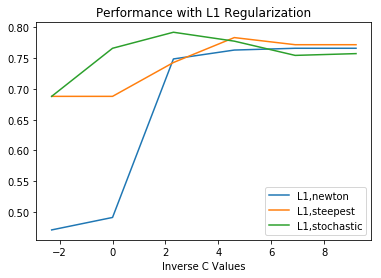

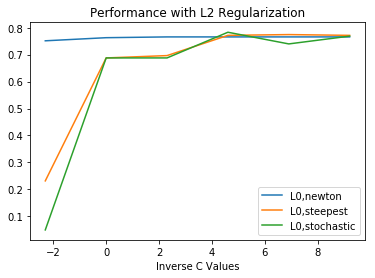

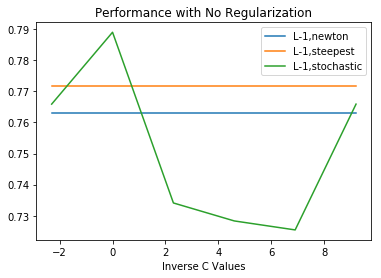

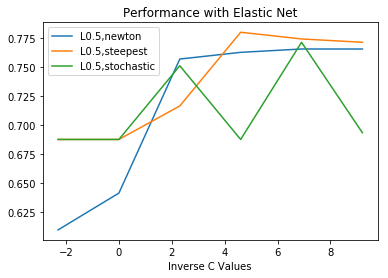

In [12]:
##L1 Regularization

df_performance = pd.DataFrame(perf_dict)
df_perf = df_performance[[col for col in df_performance if col.startswith('L1')]]
df_perf['Inverse C Values'] = [np.log(1/x) for x in c_list]
df_perf.plot(x='Inverse C Values')
plt.title("Performance with L1 Regularization")
plt.show()

##L2 Regularization

df_performance = pd.DataFrame(perf_dict)
df_perf = df_performance[[col for col in df_performance if col.startswith('L0,')]]
df_perf['Inverse C Values'] = [np.log(1/x) for x in c_list]
df_perf.plot(x='Inverse C Values')
plt.title("Performance with L2 Regularization")
plt.show()

##No Regularization

df_performance = pd.DataFrame(perf_dict)
df_perf = df_performance[[col for col in df_performance if col.startswith('L-1')]]
df_perf['Inverse C Values'] = [np.log(1/x) for x in c_list]
df_perf.plot(x='Inverse C Values')
plt.title("Performance with No Regularization")
plt.show()

##Elastic Regularization

df_performance = pd.DataFrame(perf_dict)
df_perf = df_performance[[col for col in df_performance if col.startswith('L0.5')]]
df_perf['Inverse C Values'] = [np.log(1/x) for x in c_list]
df_perf.plot(x='Inverse C Values')
plt.title("Performance with Elastic Net")
plt.show()

## Parameter Selection and Data Snooping

We optimized the parameters for C (the regularization penalty), the regularization method, and the optimization method. We got the above results using our 80/20 test split datasets. In our visualizations we see that there is a great deal of variance between each method,but generally, when we decrease C we see better performance. Regularization generally improves performance but introduces variabillity into the model. The most variable optimization method is Stochastic, and this is to be expected given its probabalistic nature in searching specific points. 

Given this data, our best model would be the stochastic optimization method with L2 regularization and a C less than 0.1. This combination outperforms any other set method we used. However, it is important to note that this method only slightly outperformed other methods, and generally the stochastic optimization method has a great deal of variation. 


This method of selecting parameters should not be expected to generalize well. Although we performed these tests on seperate and randomly selected data, we had to re-run multiple times to optimize. Our best values are in relation to this specific dataset and not in relation to any discernable or generalizable principles.

### Paramater Visualization: effects of regularization

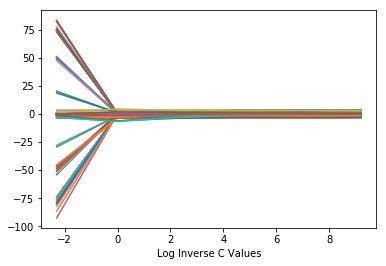

In [11]:
import pandas as pd
#Organizing the list in an easy to comprehend dictionary
classifiers = 4
params = 7
index = 0 

weight_dict = {}
perf_dict = {}

for reg in regularization_list:
    for opt in optimization_list:
        temp_list = []
        perf_list = [] 
        for c in c_list:
            temp_list.append(weights[index])
            perf_list.append(results[index])
            index += 1
        weight_dict[str(reg)+","+str(opt)] = temp_list
        perf_dict["L"+str(reg)+","+str(opt)] = perf_list
        #Merging all the params together into a vertical matrix
        for row in range(classifiers):
            for param in range(params):
                #print (temp_list[0])
                weight_dict["L"+str(reg)+","+str(opt)+",Class:"+str(row)+",Param:"+str(param)] = [x[row][param] for x in temp_list]

df = pd.DataFrame(weight_dict)
df['Log Inverse C Values'] = [np.log(1/x) for x in c_list]
df.plot(x='Log Inverse C Values',legend=False)
plt.show()

Above we graphed lists of all of the 6 parameters for the model (7 is with intercept). This is to view the general trend among the weights given different regularizations as C grows or shrinks. We see the rapid change to zero in the paramaters and the clustering to certain weights among the different models. This could suggest certain areas that all models moved to when considering weights. We see some params close out to zero earlier than others and this hints at their sensitivity to regularization. The L1 norm zeros out a weight if it is between -C/2 and C/2.

One example of this feature selection at work is the following weight array:

In [ ]:
weight_dict['1,stochastic'][-1]

# Comparison to Scikit Learn

Scikit-learn has taken  0.007001399993896484  seconds to train the model
Scikit-learn has taken  0.0010006427764892578  seconds to classify
Scikit-learn has an accuracy of:  0.8188657407407407




Our fastest multiclass method to achieve a similar accuracy is stochastic with around 15,000 iterations.
Our multi-class stochastic has taken  2.148996114730835  seconds to train the model
Our multi-class stochastic has taken  0.0010013580322265625  seconds to classify
Our multi-class stochastic has an accuracy of:  0.7934027777777778


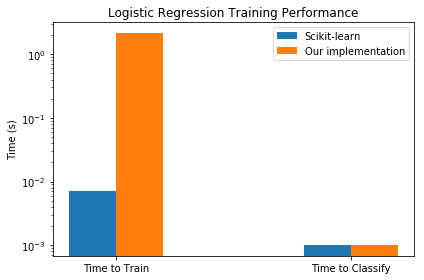

In [56]:
logistic = linear_model.LogisticRegression()
skl_bg = time.time()
logistic.fit(X,y_not_binary)
skl_nd = time.time()
skl_tr = skl_nd - skl_bg
print('Scikit-learn has taken ', skl_tr , ' seconds to train the model')

skl_bg = time.time()
yhat_sk = logistic.predict(X)
skl_nd = time.time()
skl_cl = skl_nd - skl_bg
print('Scikit-learn has taken ', skl_cl , ' seconds to classify')
print('Scikit-learn has an accuracy of: ', accuracy_score(y_not_binary, yhat_sk))

print('\n\n\n')
print('Our fastest multiclass method to achieve a similar accuracy is stochastic with around 15,000 iterations.')
lr_st = MultiClassLogisticRegression(0.1,iterations=15000,C=0.00001,optimize_func='stochastic')
mlr_bg = time.time()
lr_st.fit(X,y_not_binary)
mlr_nd = time.time()
mlr_tr = mlr_nd - mlr_bg
print('Our multi-class stochastic has taken ', mlr_tr , ' seconds to train the model')

mlr_bg = time.time()
yhat_st = lr_st.predict(X)
mlr_nd = time.time()
mlr_cl = mlr_nd - mlr_bg
print('Our multi-class stochastic has taken ', mlr_cl , ' seconds to classify')
print('Our multi-class stochastic has an accuracy of: ', accuracy_score(y_not_binary,yhat_st))

times_skl = (skl_tr, skl_cl)
times_mlr = (mlr_tr, mlr_cl)

fig, ax = plt.subplots()
index = np.arange(2)
bar_width = 0.2

theirs = plt.bar(index, times_skl, bar_width, label="Scikit-learn")
ours = plt.bar(index + bar_width, times_mlr, bar_width, label="Our implementation")


plt.ylabel('Time (s)')
plt.title('Logistic Regression Training Performance')
plt.xticks(index + bar_width/2, ('Time to Train', 'Time to Classify'))
plt.legend()
 
plt.yscale('log')
plt.tight_layout()
plt.show()


# One-versus-one Classification

In [14]:
from scipy import stats 
class MultiClassLogisticRegressionOneVersus:
    def __init__(self, eta, iterations=20, C=0.0001, optimize_func='steepest', versus='all'):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.classifiers_ = []
        self.optimize_func = optimize_func
        self.versus = versus
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []
        if self.versus == 'all':
            for i,yval in enumerate(self.unique_): # for each unique value
                y_binary = (y==yval).astype(np.int) # create a binary problem
                # train the binary classifier for this class
                if self.optimize_func == 'stochastic':
                     hblr = StochasticLogisticRegression(self.eta,self.iters,self.C)
                elif self.optimize_func == 'steepest':
                    hblr = BinaryLogisticRegression(self.eta,self.iters,self.C)
                elif self.optimize_func == 'newton':
                    hblr = NewtonLogisticRegression(self.eta,self.iters,self.C)
                hblr.fit(X,y_binary)
                # add the trained classifier to the list
                self.classifiers_.append(hblr)

            # save all the weights into one matrix, separate column for each class
            self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        elif self.versus == 'one':
            self.one_vals_ = []
            for j in range(num_unique_classes): # for each unique value
                for i in range(j):
                    y_binary = np.concatenate((y[np.array(np.where(y==j))][0],y[np.array(np.where(y==i))][0])) # create a binary problem
                    class_X = np.concatenate((X[np.array(np.where(y==j))][0],X[np.array(np.where(y==i))][0]))
                    # train the binary classifier for this class
                    if self.optimize_func == 'stochastic':
                         hblr = StochasticLogisticRegression(self.eta,self.iters,self.C)
                    elif self.optimize_func == 'steepest':
                        hblr = BinaryLogisticRegression(self.eta,self.iters,self.C)
                    elif self.optimize_func == 'newton':
                        hblr = NewtonLogisticRegression(self.eta,self.iters,self.C)
                    hblr.fit(class_X,y_binary)
                    # add the trained classifier to the list
                    self.classifiers_.append(hblr)
                    self.one_vals_.append([i,j])
            self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for hblr in self.classifiers_:
            probs.append(hblr.predict_proba(X).reshape((len(X),1))) # get probability for each classifier
        if self.versus == 'all':
            return np.hstack(probs) # make into single matrix
        elif self.versus == 'one':
            voted_probs = []
            t_probs = []
            for i in range(len(probs[0])):
                for j in range(len(probs)):
                    t_probs.append(self.one_vals_[j][np.asscalar(np.int16(np.rint(probs[j][i])[0]))])
                voted_probs.append(scipy.stats.mode(t_probs)[0][0])
                t_probs = []
            return(voted_probs)
            
    
    def predict(self,X):
        if self.versus == 'all':
            return np.argmax(self.predict_proba(X),axis=1) # take argmax along row
        elif self.versus == 'one':
            return self.predict_proba(X)

In [15]:
%%time
lr_ov = MultiClassLogisticRegressionOneVersus(0.1,iterations=1,C=0.00001,optimize_func='newton', versus='one')
lr_ov.fit(X,y_not_binary)
print(lr_ov)

yhat_ov = lr_ov.predict(X)
print('Accuracy of: ',accuracy_score(y_not_binary,yhat_ov))

MultiClass Logistic Regression Object with coefficients:
[[-1.56414912e-04 -1.63055565e-05 -1.46714784e-05  5.91201078e-06
   3.74085931e-05  1.55131505e-05  6.06043719e-05]
 [-1.24903499e-04 -3.34785291e-05 -3.20214416e-05  5.40902785e-06
   3.28191179e-05  1.20473102e-05  5.16425726e-05]
 [ 7.51728925e-04 -1.98432315e-04 -1.88959442e-04  1.74700439e-05
   1.09676964e-05  7.29341105e-05  1.15147676e-04]
 [-1.95554486e-04 -4.59534924e-05 -3.30000096e-05  1.26506655e-05
   5.03662651e-05  4.37647266e-05  1.00168798e-04]
 [ 1.99135288e-04 -3.63378111e-04 -2.92955554e-04  6.25548029e-05
   4.22814373e-05  2.64832048e-04  5.23545355e-04]
 [-1.16866989e-03  1.76409599e-04  2.55827942e-04  2.79759545e-04
   2.12462426e-04  1.21360579e-03  2.50750486e-03]]
Accuracy of:  0.6672453703703703
Wall time: 205 ms
